In [1]:
import os, sys
import openml

In [2]:
if ".." not in sys.path:
    sys.path.insert(0, "..")

In [3]:
%load_ext autoreload

%autoreload 2

In [255]:
from src.plotting import plot_roc, plot_losses
from src.modeling import NumericEmbedding, train, data_split, decision_tree_encoding, FeedForwardMLPResidual

## Try `eye_movements`

In [200]:
SUITE_ID = 297 # Regression on numerical features

In [201]:
benchmark_suite = openml.study.get_suite(SUITE_ID)  # obtain the benchmark suite

In [202]:
benchmark_suite

OpenML Benchmark Suite
ID..............: 297
Name............: Tabular benchmark numerical regression
Status..........: in_preparation
Main Entity Type: task
Study URL.......: https://www.openml.org/s/297
# of Data.......: 20
# of Tasks......: 20
Creator.........: https://www.openml.org/u/26324
Upload Time.....: 2022-07-10 10:45:09

In [203]:
# benchmark_suite.tasks

In [204]:
task_id = 361070 # eye movement
# task_id = 361060 # electricity
# task_id = 361056 # california
# task_id = 361071 # jannis

In [205]:
task = openml.tasks.get_task(task_id)  # download the OpenML task
dataset = task.get_dataset()

In [305]:
df, y, categorical_indicator, features = dataset.get_data(
    dataset_format="dataframe", target=dataset.default_target_attribute
)
y = (y==y[0]).astype(int).values

In [207]:
df.head()

,lineNo,assgNo,prevFixDur,firstfixDur,firstPassFixDur,nextFixDur,firstSaccLen,lastSaccLen,prevFixPos,landingPos,leavingPos,totalFixDur,meanFixDur,regressLen,regressDur,pupilDiamMax,pupilDiamLag,timePrtctg,titleNo,wordNo
0,9684.0,298.0,99.0,119.0,119.0,238.0,300.1666,288.0156,246.0732,56.6326,51.1786,119.0,119.0000,0.0,0.0,0.1541,0.4446,0.0176,4,3
1,2065.0,66.0,119.0,159.0,239.0,100.0,306.1066,117.2359,321.0140,47.3207,47.0425,239.0,119.5000,0.0,159.0,0.0119,0.3264,0.0239,8,1
2,1969.0,61.0,139.0,139.0,357.0,179.0,590.5294,805.0531,479.3078,112.3610,118.6529,536.0,178.6667,258.0,0.0,0.0874,0.0859,0.0431,4,8
3,10326.0,315.0,199.0,139.0,219.0,99.0,80.9475,306.5587,153.1698,79.8389,78.5875,198.0,99.0000,0.0,396.0,0.0173,0.1453,0.0264,4,2
4,6827.0,204.0,80.0,100.0,239.0,139.0,110.7576,161.4845,189.6207,96.7471,102.1225,139.0,139.0000,0.0,378.0,0.3229,0.4074,0.0288,2,1


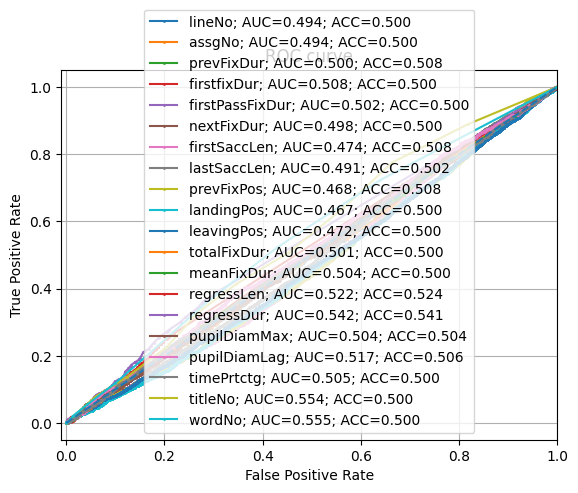

In [208]:
plot_roc(y, [df[c].values for c in features], features, x_max=1.0)

## Modeling
### Data splitting

In [209]:
Xs, ys = data_split(df.values, y, 0.7, 0.09)

In [210]:
{k: v.shape for k, v in Xs.items()}

{'train': torch.Size([5325, 20]),
 'valid': torch.Size([684, 20]),
 'test': torch.Size([1599, 20])}

In [211]:
{k: v.shape for k, v in ys.items()}

{'train': torch.Size([5325]),
 'valid': torch.Size([684]),
 'test': torch.Size([1599])}

### Random Forest

In [212]:
from sklearn.ensemble import RandomForestClassifier

In [213]:
clf_rf = RandomForestClassifier(n_estimators=300, max_depth=12)

In [214]:
clf_rf.fit(Xs['train'], ys['train'])

RandomForestClassifier(max_depth=12, n_estimators=300)

In [215]:
y_hat_rf = clf_rf.predict_proba(Xs['test'])[:,1]

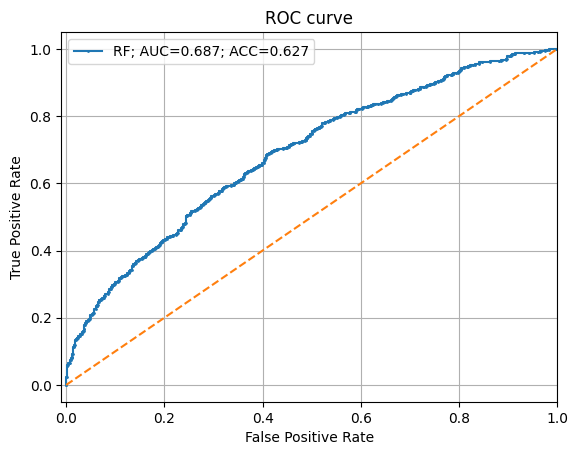

In [216]:
plot_roc(ys['test'],[y_hat_rf], ['RF'])

### XGBoost

In [371]:
from xgboost import XGBClassifier

In [458]:
# create model instance
bst = XGBClassifier(
    n_estimators=1000, 
    max_depth=6, 
    learning_rate=0.05, objective='binary:logistic',
#     subsample=0.5,
#     min_child_weight=3,
#     reg_lambda=2,
    reg_alpha=2,
    early_stopping_rounds=40
)

In [459]:
# fit model
bst.fit(
    Xs['train'], ys['train'], 
    eval_set=[(Xs['train'], ys['train']), (Xs['valid'], ys['valid'])]
)

[0]	validation_0-logloss:0.68783	validation_1-logloss:0.69073
[1]	validation_0-logloss:0.68263	validation_1-logloss:0.68755
[2]	validation_0-logloss:0.67806	validation_1-logloss:0.68572
[3]	validation_0-logloss:0.67358	validation_1-logloss:0.68363
[4]	validation_0-logloss:0.66936	validation_1-logloss:0.68200
[5]	validation_0-logloss:0.66570	validation_1-logloss:0.68010
[6]	validation_0-logloss:0.66165	validation_1-logloss:0.67841
[7]	validation_0-logloss:0.65802	validation_1-logloss:0.67763
[8]	validation_0-logloss:0.65415	validation_1-logloss:0.67587
[9]	validation_0-logloss:0.65066	validation_1-logloss:0.67487
[10]	validation_0-logloss:0.64729	validation_1-logloss:0.67464
[11]	validation_0-logloss:0.64392	validation_1-logloss:0.67416
[12]	validation_0-logloss:0.64071	validation_1-logloss:0.67258
[13]	validation_0-logloss:0.63783	validation_1-logloss:0.67175
[14]	validation_0-logloss:0.63490	validation_1-logloss:0.67092
[15]	validation_0-logloss:0.63220	validation_1-logloss:0.67023
[1

[130]	validation_0-logloss:0.46226	validation_1-logloss:0.63654
[131]	validation_0-logloss:0.46173	validation_1-logloss:0.63600
[132]	validation_0-logloss:0.46066	validation_1-logloss:0.63588
[133]	validation_0-logloss:0.45968	validation_1-logloss:0.63577
[134]	validation_0-logloss:0.45834	validation_1-logloss:0.63570
[135]	validation_0-logloss:0.45768	validation_1-logloss:0.63554
[136]	validation_0-logloss:0.45642	validation_1-logloss:0.63566
[137]	validation_0-logloss:0.45521	validation_1-logloss:0.63536
[138]	validation_0-logloss:0.45440	validation_1-logloss:0.63530
[139]	validation_0-logloss:0.45412	validation_1-logloss:0.63494
[140]	validation_0-logloss:0.45322	validation_1-logloss:0.63504
[141]	validation_0-logloss:0.45203	validation_1-logloss:0.63484
[142]	validation_0-logloss:0.45177	validation_1-logloss:0.63457
[143]	validation_0-logloss:0.45074	validation_1-logloss:0.63423
[144]	validation_0-logloss:0.45043	validation_1-logloss:0.63430
[145]	validation_0-logloss:0.44966	valid

[259]	validation_0-logloss:0.36521	validation_1-logloss:0.63008
[260]	validation_0-logloss:0.36439	validation_1-logloss:0.62988
[261]	validation_0-logloss:0.36376	validation_1-logloss:0.63029
[262]	validation_0-logloss:0.36324	validation_1-logloss:0.63026
[263]	validation_0-logloss:0.36267	validation_1-logloss:0.63010
[264]	validation_0-logloss:0.36200	validation_1-logloss:0.63006
[265]	validation_0-logloss:0.36147	validation_1-logloss:0.63007
[266]	validation_0-logloss:0.36075	validation_1-logloss:0.63031
[267]	validation_0-logloss:0.35999	validation_1-logloss:0.63022
[268]	validation_0-logloss:0.35927	validation_1-logloss:0.63072
[269]	validation_0-logloss:0.35879	validation_1-logloss:0.63085
[270]	validation_0-logloss:0.35830	validation_1-logloss:0.63055
[271]	validation_0-logloss:0.35760	validation_1-logloss:0.63059
[272]	validation_0-logloss:0.35663	validation_1-logloss:0.63050
[273]	validation_0-logloss:0.35618	validation_1-logloss:0.63047
[274]	validation_0-logloss:0.35576	valid

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=40, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [460]:
# make predictions
y_hat_xgb = bst.predict_proba(Xs['test'])[:,1]

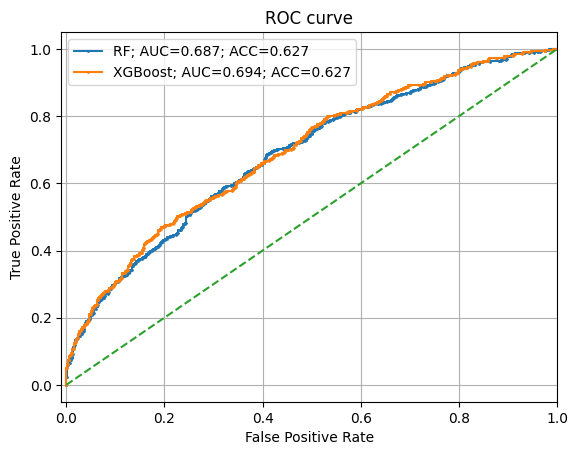

In [461]:
plot_roc(ys['test'],[y_hat_rf, y_hat_xgb], ['RF', 'XGBoost'])

## NN

In [329]:
from torch import nn

In [330]:
N_epochs = 5000
stop_criteria = 200

### Raw features

In [462]:
# model_raw = nn.Linear(Xs['train'].shape[1], 1)
hidden_dim = 64
# model_raw = nn.Sequential(
#     nn.Linear(Xs['train'].shape[1], hidden_dim),
#     nn.Dropout(0.5),
#     nn.ReLU(),
#     nn.Linear(hidden_dim, 1),
# )
model_raw = nn.Sequential(
    FeedForwardMLPResidual(
        d_model=Xs['train'].shape[1], dim_feedforward=hidden_dim, dropout=0.1,
    ),
#     FeedForwardMLPResidual(
#         d_model=Xs['train'].shape[1], dim_feedforward=hidden_dim, dropout=0.5,
#     ),
    nn.Linear(Xs['train'].shape[1], 1),
)

In [463]:
sum([p.numel() for p in model_raw.parameters()])

2705

In [464]:
train_losses, test_losses, y_hat_raw = train(
    model_raw, Xs['train'], ys['train'], Xs['valid'], ys['valid'], Xs['test'], 
    N_epochs, stop_criteria=stop_criteria
)

Early stopping at epoch 519 with valid acc 0.553


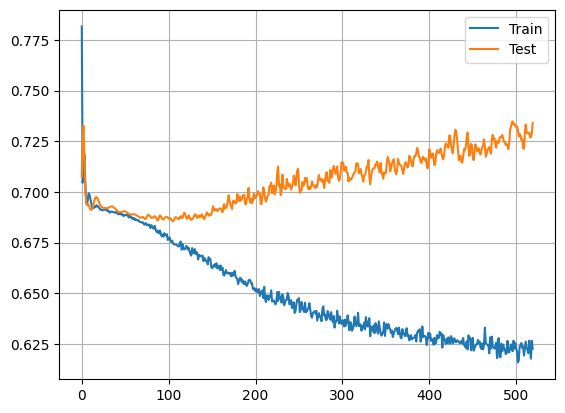

In [465]:
plot_losses(train_losses, test_losses)

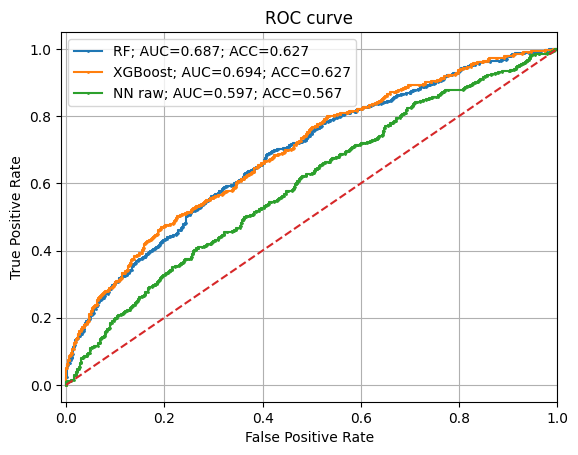

In [466]:
plot_roc(ys['test'],[y_hat_rf, y_hat_xgb, y_hat_raw], ['RF', 'XGBoost', 'NN raw'])

### DT encoding

In [467]:
# eye-movement min_impurity_decrease=1e-4
# electricity min_impurity_decrease=2e-5
# california min_impurity_decrease=2e-4
Xs_dt, decision_trees, leaf_encoders = decision_tree_encoding(Xs, ys, min_impurity_decrease=1e-4)#, max_splits=20)

In [468]:
n_uniques = (Xs_dt['train'].max(dim=0)[0]+1).numpy()
n_uniques

array([1013,  117,   10,   19,   29,   16, 1004, 1067,  884,  684,  848,
         20,   13,  125,   85,  705,  644,  173,    9,    7])

In [469]:
embed_dim = 1
hidden_dim = 1028
# model = nn.Sequential(NumericEmbedding(n_uniques, 1, 'concat'), nn.Linear(len(topN), 1))
# model_dt = nn.Sequential(
#     NumericEmbedding(n_uniques, embed_dim, 'concat'),
#     nn.Linear(n_uniques.shape[0]*embed_dim, hidden_dim),
#     nn.Dropout(0.2),
#     nn.ReLU(),
#     nn.Linear(hidden_dim, 1),
# )

model_dt = nn.Sequential(
    NumericEmbedding(n_uniques, embed_dim, 'concat'),
    FeedForwardMLPResidual(
        d_model=n_uniques.shape[0]*embed_dim, dim_feedforward=hidden_dim, dropout=0.1,
    ),
#     FeedForwardMLPResidual(
#         d_model=n_uniques.shape[0]*embed_dim, dim_feedforward=hidden_dim, dropout=0.1,
#     ),
    nn.Linear(n_uniques.shape[0]*embed_dim, 1),
)
# model_dt = nn.Sequential(
#     NumericEmbedding(n_uniques, embed_dim, 'concat'),
#     nn.Linear(n_uniques.shape[0]*embed_dim, hidden_dim),
#     nn.Dropout(0.2),
#     nn.ReLU(),
#     nn.Linear(hidden_dim, 1),
# )
# model = nn.Sequential(NumericEmbedding(n_uniques, 8, 'mean'), nn.Linear(8, 1))

In [470]:
model_dt

Sequential(
  (0): NumericEmbedding(
    (embeds): ModuleList(
      (0): Embedding(1013, 1)
      (1): Embedding(117, 1)
      (2): Embedding(10, 1)
      (3): Embedding(19, 1)
      (4): Embedding(29, 1)
      (5): Embedding(16, 1)
      (6): Embedding(1004, 1)
      (7): Embedding(1067, 1)
      (8): Embedding(884, 1)
      (9): Embedding(684, 1)
      (10): Embedding(848, 1)
      (11): Embedding(20, 1)
      (12): Embedding(13, 1)
      (13): Embedding(125, 1)
      (14): Embedding(85, 1)
      (15): Embedding(705, 1)
      (16): Embedding(644, 1)
      (17): Embedding(173, 1)
      (18): Embedding(9, 1)
      (19): Embedding(7, 1)
    )
  )
  (1): FeedForwardMLPResidual(
    (linear1): Linear(in_features=20, out_features=1028, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1028, out_features=20, bias=True)
    (norm): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (2): Linear(in_f

In [471]:
sum([p.numel() for p in model_dt.parameters()])

49701

In [472]:
# {k: v.abs().sum().item() for k, v in model_dt[0].named_parameters()}

In [473]:
train_losses_dt, test_losses_dt, y_hat_dt = train(
    model_dt, Xs_dt['train'], ys['train'], Xs_dt['valid'], ys['valid'], Xs_dt['test'], 
    N_epochs, 
    stop_criteria=stop_criteria, 
    l1_lambda=1e-3,
)

Early stopping at epoch 450 with valid acc 0.692


In [474]:
# {k: v.abs().sum().item() for k, v in model_dt[0].named_parameters()}

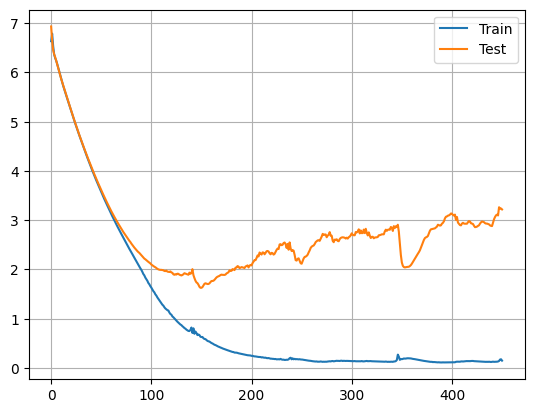

In [475]:
plot_losses(train_losses_dt, test_losses_dt)

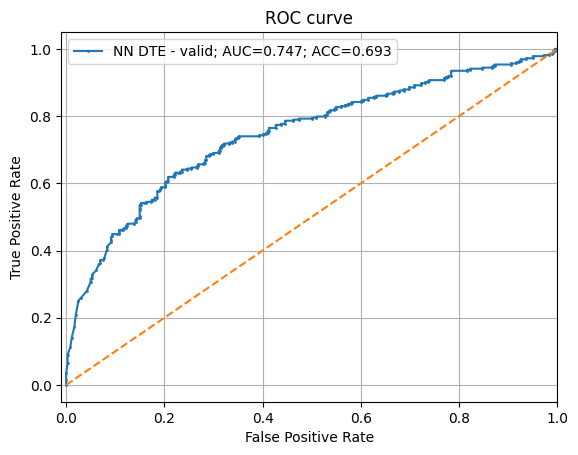

In [476]:
plot_roc(ys['valid'],[model_dt(Xs_dt['valid']).flatten().sigmoid().detach().numpy()], ['NN DTE - valid'])

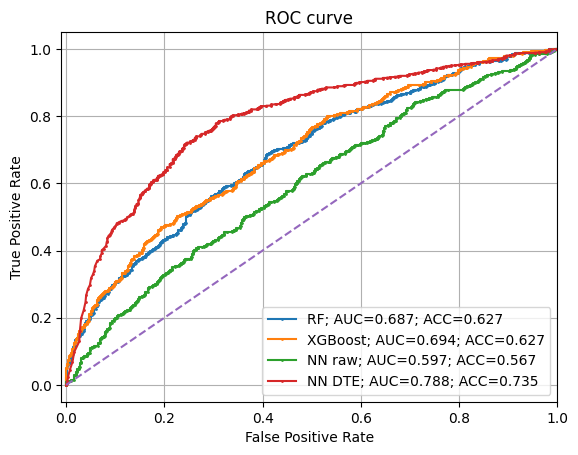

In [477]:
plot_roc(ys['test'],[y_hat_rf, y_hat_xgb, y_hat_raw, y_hat_dt], ['RF', 'XGBoost', 'NN raw', 'NN DTE'])